<a href="https://colab.research.google.com/github/arthur422tp/arthur422/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
###載入套件(經典tensorflow版本又在搞)
!pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from ipywidgets import interact, IntSlider, FloatSlider
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

調整一下資料

In [48]:
###使用MNIST的資料就好
(X_train, Y_train), (X_test, Y_test) = datasets.mnist.load_data()

看一下維度，然後reshape

In [49]:
X_train.shape

(60000, 28, 28)

In [50]:
X_train = X_train.reshape(-1, 28*28)

In [51]:
X_train.shape

(60000, 784)

In [52]:
print(X_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [78]:
X_test = X_test.reshape(-1, 28*28)

Normalization

In [79]:
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

One-hot encoding

In [80]:
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)

設定參數、建模型

In [81]:
batch_size = 100
FirstLayer_dimension = 784
SecondLayer_dimension = 256
FinalLayer_dimension = 2
epochs = 30

In [82]:
x_0 = Input(shape=(FirstLayer_dimension,))
x_1 = Dense(SecondLayer_dimension, activation='sigmoid')(x_0)
x_2 = Dense(FinalLayer_dimension, activation='sigmoid')(x_1)

z_mean = Dense(FinalLayer_dimension)(x_1)
z_log_var = Dense(FinalLayer_dimension)(x_1)

###lambda層

def sample(args):
  z_mean, z_log_var = args
  batch = K.shape(z_mean)[0]
  eps = K.random_normal(shape=(batch_size, FinalLayer_dimension), mean=0)
  return z_mean + K.exp(z_log_var/2)*eps
###Normal Distribution



In [83]:
z = Lambda(sample, output_shape=(FinalLayer_dimension,))([z_mean, z_log_var])

###decoder layer
dec_x1 = Dense(SecondLayer_dimension, activation='sigmoid')
dec_mean = Dense(FirstLayer_dimension, activation='sigmoid')

x_hat = dec_mean(dec_x1(z))

VAE = Model(inputs=x_0, outputs=x_hat)
VAE.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 784)]                0         []                            
                                                                                                  
 dense_47 (Dense)            (None, 256)                  200960    ['input_17[0][0]']            
                                                                                                  
 dense_49 (Dense)            (None, 2)                    514       ['dense_47[0][0]']            
                                                                                                  
 dense_50 (Dense)            (None, 2)                    514       ['dense_47[0][0]']            
                                                                                            

定義loss function

In [84]:
reconstruction_loss = losses.mean_squared_error(K.flatten(x_0), K.flatten(x_hat))
reconstruction_loss *= FirstLayer_dimension

# KL Loss
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

# VAE Loss
vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)
VAE.compile(optimizer='adam')

VAE.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 784)]                0         []                            
                                                                                                  
 dense_47 (Dense)            (None, 256)                  200960    ['input_17[0][0]']            
                                                                                                  
 dense_49 (Dense)            (None, 2)                    514       ['dense_47[0][0]']            
                                                                                                  
 dense_50 (Dense)            (None, 2)                    514       ['dense_47[0][0]']            
                                                                                            

終於 可以訓練了

In [85]:
VAE.compile(optimizer=Adam())

In [86]:
VAE.fit(X_train, X_train, batch_size, epochs)

Epoch 1/30
600/600 [==============================] - 6s 8ms/step - loss: 52.3447
Epoch 2/30
600/600 [==============================] - 5s 8ms/step - loss: 47.3063
Epoch 3/30
600/600 [==============================] - 5s 9ms/step - loss: 46.9074
Epoch 4/30
600/600 [==============================] - 5s 8ms/step - loss: 46.6275
Epoch 5/30
600/600 [==============================] - 6s 10ms/step - loss: 46.4322
Epoch 6/30
600/600 [==============================] - 5s 8ms/step - loss: 45.8900
Epoch 7/30
600/600 [==============================] - 5s 9ms/step - loss: 45.1474
Epoch 8/30
600/600 [==============================] - 5s 8ms/step - loss: 44.3189
Epoch 9/30
600/600 [==============================] - 5s 8ms/step - loss: 43.3759
Epoch 10/30
600/600 [==============================] - 5s 9ms/step - loss: 42.5126
Epoch 11/30
600/600 [==============================] - 5s 8ms/step - loss: 41.8619
Epoch 12/30
600/600 [==============================] - 5s 9ms/step - loss: 41.3631
Epoch 13/30


encoder的可視化

100/100 [==============================] - 0s 2ms/step


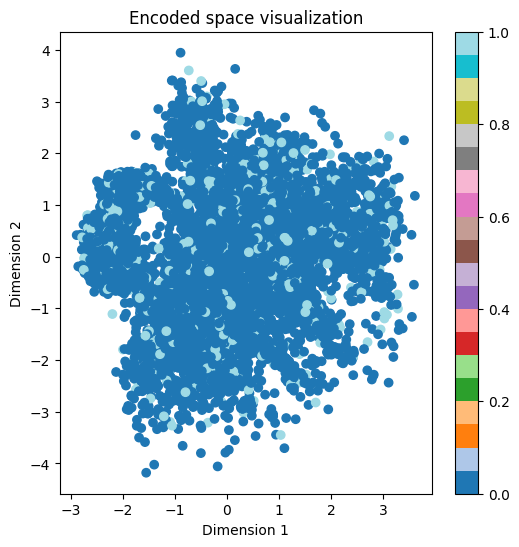

In [105]:
###隨機抽個幾個出來
indices = np.random.randint(X_train.shape[0], size=10)



encoder = Model(inputs=x_0, outputs=z_mean)
X_test_encoder = encoder.predict(X_test, batch_size=batch_size)

plt.figure(figsize=(6,6))
plt.scatter(X_test_encoder[:,0],X_test_encoder[:,1],c=Y_train[indices], cmap='tab20')
plt.colorbar()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Encoded space visualization')
plt.show()
plt.show()